In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

변환하고자 하는 이미지를 선택

In [2]:
cat_in_snow  = tf.keras.utils.get_file(
    '320px-Felis_catus-cat_on_snow.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg')

image_string = open(cat_in_snow, 'rb').read()
image = tf.io.decode_jpeg(image_string)

32768/17858 [=======================================================] - 0s 0us/step


In [3]:
def test_deprocess(img):
  img = tf.cast(img, dtype=tf.float32) / 255.0
  return tf.cast(img, tf.uint32)

# 이미지를 정규화합니다.
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

**특징 추출이 가능한 모델을 선택 및 불러오기**

딥드림은 활성화시킬 하나 혹은 그 이상의 층을 선택한 후 "손실"을 최대화하도록 이미지를 수정함으로써 선택한 층을 "흥분"시키는 원리를 기반으로 합니다. 얼마나 복잡한 특성이 나타날지는 선택한 층에 따라 다르게 됩니다. 낮은 층을 선택한다면 획 또는 간단한 패턴이 향상되고, 깊은 층을 선택한다면 이미지 내의 복잡한 패턴이나 심지어 물체의 모습도 생성할 수 있습니다.

InceptionV3에는 'mixed0'부터 'mixed10'까지 총 11개의 이러한 합성곱층이 있습니다. 이 중 어떤 층을 선택하느냐에 따라서 딥드림 이미지의 모습이 결정됩니다. 깊은 층은 눈이나 얼굴과 같은 고차원 특성(higher-level features)에 반응하는 반면, 낮은 층은 선분이나 모양, 질감과 같은 저차원 특성에 반응합니다. 임의의 층을 선택해 자유롭게 실험해보는 것도 가능합니다. 다만 깊은 층(인덱스가 높은 층)은 훈련을 위한 그래디언트 계산에 시간이 오래 걸릴 수 있습니다.

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [5]:
# 선택한 층들의 활성화값을 최대화합니다.
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# 특성 추출 모델을 만듭니다.
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [6]:
dream_model.output

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

# **손실 계산하기**

손실은 선택한 층들의 활성화값의 총 합으로 계산됩니다. 층의 크기와 상관 없이 모든 활성화값이 동일하게 고려될 수 있도록 각 층의 손실을 정규화합니다. 일반적으로, 손실은 경사하강법으로 최소화하고자 하는 수치입니다. 하지만 딥드림에서는 예외적으로 이 손실을 경사상승법(gradient ascent)을 통해 최대화할 것입니다.

In [13]:
def calc_loss(img, model):
    # 이미지를 순전파시켜 모델의 활성화값을 얻습니다.
    # 이미지의 배치(batch) 크기를 1로 만듭니다.
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch) # relu 거친 activation map의 값
    
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act) # 손실은 선택한 층들의 활성화값의 총 합으로 계산
        losses.append(loss)

    # 선택한 층마다의 활성화 평균 값.
    print('len : ', len(losses))

    return  tf.reduce_sum(losses)

In [14]:
calc_loss(test_deprocess(image), dream_model)

len :  2


<tf.Tensor: shape=(), dtype=float32, numpy=0.52035284>

# **경사상승법**

선택한 층의 손실을 구했다면, 이제 남은 순서는 **입력 이미지에 대한 그래디언트를 계산하여 원본 이미지에 추가**하는 것입니다.

원본 이미지에 그래디언트를 더하는 것은 신경망이 보는 이미지 내의 패턴을 향상시키는 일에 해당합니다. 

훈련이 진행될수록 신경망에서 선택한 층을 더욱더 활성화시키는 이미지를 생성할 수 있습니다.

In [15]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model # 모델 정의

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32), # Tensor 설명
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # `img`에 대한 그래디언트가 필요합니다.
          # `GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img)

          # 순전파 후, 2개의 activation map에 대한 평균 손실을 return.
          loss = calc_loss(img, self.model)

        # 입력 이미지의 각 픽셀에 대한 손실 함수의 그래디언트를 계산합니다. 편미분 과정.
        gradients = tape.gradient(loss, img)

        # 편차로 나누어서 그래디언트를 정규화합니다.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        

        # 경사상승법을 이용해 "손실" 최대화함으로써 입력 이미지가 선택한 층들을 보다 더 "흥분" 시킬 수 있도록 합니다.
        # (그래디언트와 이미지의 차원이 동일하므로) 그래디언트를 이미지에 직접 더함으로써 이미지를 업데이트할 수 있습니다.
        img = img + gradients*step_size # element-wise 형태.

        # 넘치는 값에 대한 규제.
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [16]:
deepdream = DeepDream(dream_model)

Main loop

In [29]:
# 이미지를 출력합니다.
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # 이미지를 모델에 순전파하기 위해 uint8 형식으로 변환합니다.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)

  # step size는 learning rate와 유사한 작업을 수행.
  step_size = tf.convert_to_tensor(step_size)

  # 최대 epoch과 현재 epoch을 저장.
  steps_remaining = steps
  step = 0

  # 훈련을 위한 최대 epoch을 선정한 듯.
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)

    steps_remaining -= run_steps
    step += run_steps

    # 정의된 모델에 매개변수를 전달하며 순전파 등의 전체 과정을 1회 수행.
    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img)) # 이미지의 정규화 후 출력.
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

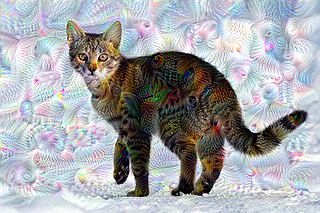

In [30]:
dream_img = run_deep_dream_simple(img=tf.cast(image, dtype=tf.float32), 
                                  steps=100, step_size=0.01)

# Deep Dream 최적화하기

**지금 생성된 이미지도 상당히 인상적이지만, 위의 시도는 몇 가지 문제점들을 안고 있습니다:**

생성된 이미지에 노이즈(noise)가 많이 끼어있습니다 (이 문제는 tf.image.total_variation loss로 해결할 수 있습니다).

생성된 이미지의 해상도가 낮습니다.

패턴들이 모두 균일한 입도(granularity)로 나타나고 있습니다. -> 분할된 정도를 의미


이 문제들을 해결할 수 있는 한 가지 방법은 경사상승법의 스케일(scale)를 달리하여 여러 차례 적용하는 것입니다. 이는 작은 스케일에서 생성된 패턴들이 큰 스케일에서 생성된 패턴들에 녹아들어 더 많은 디테일을 형성할 수 있도록 해줍니다.

이 작업을 실행하기 위해서는 이전에 구현한 경사상승법을 사용한 후, 이미지의 크기(이를 옥타브라고 부릅니다)를 키우고 여러 옥타브에 대해 이 과정을 반복합니다.

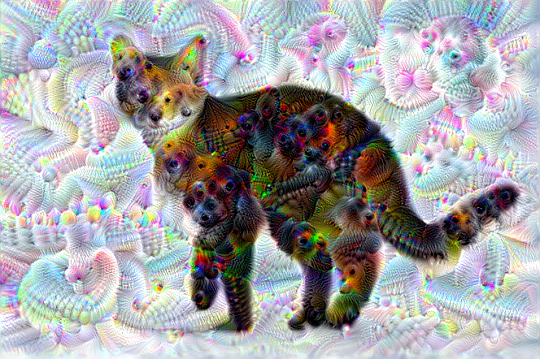

In [36]:
import time
start = time.time()

# 스케일 조정을 위해 옥타브를 활용.
OCTAVE_SCALE = 1.30

# (<tf.Tensor: shape=(2,), dtype=int32, numpy=array([213, 320], dtype=int32)>,
# <tf.Tensor: shape=(2,), dtype=float32, numpy=array([213., 320.], dtype=float32)>)
img = tf.constant(np.array(image))
base_shape = tf.shape(img)[:-1] # 이미지의 shape을 구함.
float_base_shape = tf.cast(base_shape, tf.float32) # shape에 대해 float32 형태로 casting.

# -2에서 2까지 loop
# 하나의 이미지에 대해서 여러 번 스케일을 조정함.
for n in range(-2, 3):
    # 배율을 통해 이미지의 새로운 shape을 결정.
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    # 결정된 shape을 적용하여 이미지 크기를 resize.
    img = tf.image.resize(img, new_shape).numpy()

    # resized 이미지를 적용하여 경사상승법 훈련을 진행.
    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)


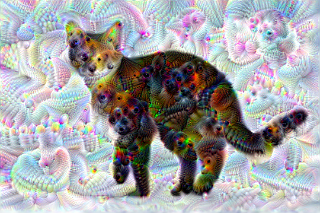

131.41425848007202

In [37]:
display.clear_output(wait=True)

# 변환이 완료된 이미지를 원본 이미지로 복구.
img = tf.image.resize(img, base_shape)

# 깔끔하게 맞아 떨어지게, int 형태로 형성.
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

# 변환에 사용된 시간을 출력.
end = time.time()
end-start